# Figure 1C - YARN Normalization Version

Heatplot representing similarity in the fold-changes between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues</b>

In [3]:
rm(list = ls())

We downloaded the GTEx version 8.0 RNA-seq and genotype data (phs000424.v8.v2), released 2019-08-26.
We used YARN (https://bioconductor.org/packages/release/bioc/html/yarn.html), uploading the downloadGTEx function
to download this release, and used it to perform quality control, gene filtering and normalization pre-processing on the
GTEx RNA-seq data, as described in (Paulson et al, 2017).   This pipelines tested for sample sex-misidentification, 
merged related sub-tissues, performed tissue-aware normalization using qsmooth (Hicks et al, 2017).

In [4]:
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")
BiocManager::install("yarn")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'yarn'




The downloaded binary packages are in
	/var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//RtmpaZT0De/downloaded_packages


Old packages: 'boot', 'DT', 'foreign', 'MASS', 'mime', 'nlme', 'processx',
  'rstudioapi'



In [5]:
BiocManager::install("downloader")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'downloader'




The downloaded binary packages are in
	/var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//RtmpaZT0De/downloaded_packages


Old packages: 'boot', 'DT', 'foreign', 'MASS', 'mime', 'nlme', 'processx',
  'rstudioapi'



In [6]:
BiocManager::install("readr")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'readr'




The downloaded binary packages are in
	/var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//RtmpaZT0De/downloaded_packages


Old packages: 'boot', 'DT', 'foreign', 'MASS', 'mime', 'nlme', 'processx',
  'rstudioapi'



In [14]:
BiocManager::install("biomaRt")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'biomaRt'




The downloaded binary packages are in
	/var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//RtmpaZT0De/downloaded_packages


Old packages: 'boot', 'DT', 'foreign', 'MASS', 'mime', 'nlme', 'processx',
  'rstudioapi'



In [7]:
library(yarn)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

In [8]:
library(downloader)

In [9]:
library(readr)

In [15]:
library(biomaRt)

Define a V8 of the function from YARN - wrote the author to make this perhaps version - or I guess I could update the package itself.
THere were 3 lines to change for each of the source files

In [18]:
downloadGTExV8=function (type = "genes", file = NULL, ...) 
{
    phenoFile <- "https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
    pheno2File <- "https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt"
    geneFile <- "https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz"
    message("Downloading and reading files")
    pdFile <- tempfile("phenodat", fileext = ".txt")
    download(phenoFile, destfile = pdFile)
    pd <- read_tsv(pdFile)
    pd <- as.matrix(pd)
    rownames(pd) <- pd[, "SAMPID"]
    ids <- sapply(strsplit(pd[, "SAMPID"], "-"), function(i) paste(i[1:2], 
        collapse = "-"))
    pd2File <- tempfile("phenodat2", fileext = ".txt")
    download(pheno2File, destfile = pd2File)
    pd2 <- read_tsv(pd2File)
    pd2 <- as.matrix(pd2)
    rownames(pd2) <- pd2[, "SUBJID"]
    pd2 <- pd2[which(rownames(pd2) %in% unique(ids)), ]
    pd2 <- pd2[match(ids, rownames(pd2)), ]
    rownames(pd2) <- colnames(counts)
    pdfinal <- AnnotatedDataFrame(data.frame(cbind(pd, pd2)))
    if (type == "genes") {
        countsFile <- tempfile("counts", fileext = ".gz")
        download(geneFile, destfile = countsFile)
        cnts <- suppressWarnings(read_tsv(geneFile, skip = 2))
        genes <- unlist(cnts[, 1])
        geneNames <- unlist(cnts[, 2])
        counts <- cnts[, -c(1:2)]
        counts <- as.matrix(counts)
        rownames(counts) <- genes
        for (i in 1:nrow(problems(cnts))) {
            counts[problems(cnts)$row[i], problems(cnts)$col[i]] <- 1e+05
        }
        throwAway <- which(rowSums(counts) == 0)
        counts <- counts[-throwAway, ]
        genes <- sub("\\..*", "", rownames(counts))
        host <- "www.ensembl.org"
        biomart <- "ENSEMBL_MART_ENSEMBL"
        dataset <- "hsapiens_gene_ensembl"
        attributes <- c("ensembl_gene_id", "hgnc_symbol", "chromosome_name", 
            "start_position", "end_position", "gene_biotype")
    }
    message("Creating ExpressionSet")
    pdfinal <- pdfinal[match(colnames(counts), rownames(pdfinal)), 
        ]
    es <- ExpressionSet(as.matrix(counts))
    phenoData(es) <- pdfinal
    pData(es)["GTEX-YF7O-2326-101833-SM-5CVN9", "SMTS"] <- "Skin"
    pData(es)["GTEX-YEC3-1426-101806-SM-5PNXX", "SMTS"] <- "Stomach"
    message("Annotating from biomaRt")
    es <- annotateFromBiomart(obj = es, genes = genes, host = host, 
        biomart = biomart, dataset = dataset, attributes = attributes)
    message("Cleaning up files")
    unlink(pdFile)
    unlink(pd2File)
    unlink(countsFile)
    if (!is.null(file)) 
        saveRDS(es, file = file)
    return(es)
}


Now call the function downloadGTExV8 of the file, store it locally)

In [19]:
#obj <- downloadGTExV8(type='genes',file='data/gtex.rds')


Parsed with column specification:
cols(
  .default = col_double(),
  SAMPID = col_character(),
  SMCENTER = col_character(),
  SMPTHNTS = col_character(),
  SMTS = col_character(),
  SMTSD = col_character(),
  SMUBRID = col_character(),
  SMNABTCH = col_character(),
  SMNABTCHT = col_character(),
  SMNABTCHD = col_character(),
  SMGEBTCH = col_character(),
  SMGEBTCHD = col_character(),
  SMGEBTCHT = col_character(),
  SMAFRZE = col_character(),
  SMGTC = col_logical(),
  SMNUMGPS = col_logical(),
  SM550NRM = col_logical(),
  SM350NRM = col_logical(),
  SMMNCPB = col_logical(),
  SMMNCV = col_logical(),
  SMCGLGTH = col_logical()
  # ... with 2 more columns
)

See spec(...) for full column specifications.

Warning message:
“379 parsing failures.
  row   col           expected            actual                                                                                     file
14837 SMGTC 1/0/T/F/TRUE/FALSE 6293764057_R01C01 '/var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//Rtmp

In [33]:
library(devtools)

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:downloader’:

    source_url




If you have already downloaded the file, you may now upload it again here:

In [56]:
getwd()

[1] "/Users/adeslat/Desktop/2020/2020Lifebit/rMATSPaperData/lifebitCloudOSDRE"

In [57]:
setwd("..")
getwd()

[1] "/Users/adeslat/Desktop/2020/2020Lifebit/rMATSPaperData"

In [58]:
library(devtools)

In [59]:
uninstall("yarn")

Uninstalling yarn

Removing package from ‘/Library/Frameworks/R.framework/Versions/3.6/Resources/library’
(as ‘lib’ is unspecified)



In [60]:
install("yarn")

Skipping 36 packages ahead of CRAN: Biobase, biomaRt, edgeR, limma, preprocessCore, quantro, BiocGenerics, AnnotationDbi, minfi, IRanges, S4Vectors, GenomicRanges, SummarizedExperiment, Biostrings, bumphunter, GenomeInfoDb, siggenes, illuminaio, DelayedMatrixStats, genefilter, GEOquery, DelayedArray, HDF5Array, BiocParallel, XVector, GenomicFeatures, annotate, GenomeInfoDbData, rhdf5, Rhdf5lib, multtest, rtracklayer, zlibbioc, Rsamtools, GenomicAlignments, Rhtslib



✔  checking for file ‘/Users/adeslat/Desktop/2020/2020Lifebit/rMATSPaperData/yarn/DESCRIPTION’
─  preparing ‘yarn’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘yarn_1.13.1.tar.gz’ (501ms)
   
Running /Library/Frameworks/R.framework/Resources/bin/R CMD INSTALL \
  /var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//RtmpaZT0De/yarn_1.13.1.tar.gz \
  --install-tests 
* installing to library ‘/Library/Frameworks/R.framework/Versions/3.6/Resources/library’
* installing *source* package ‘yarn’ ...
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** tests
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testin

In [2]:
library(yarn)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

In [3]:
getwd()

[1] "/Users/adeslat/Desktop/2020/2020Lifebit/rMATSPaperData/lifebitCloudOSDRE"

In [4]:
#setwd("lifebitCloudOSDRE")
obj<-readRDS('data/gtex.rds')

In [5]:
obj

ExpressionSet (storageMode: lockedEnvironment)
assayData: 55878 features, 17382 samples 
  element names: exprs 
protocolData: none
phenoData
  rowNames: GTEX-1117F-0226-SM-5GZZ7 GTEX-1117F-0426-SM-5EGHI ...
    GTEX-YEC3-1426-101806-SM-5PNXX (17384 total)
  varLabels: SAMPID SMATSSCR ... DTHHRDY (67 total)
  varMetadata: labelDescription
featureData
  featureNames: ENSG00000223972.5 ENSG00000227232.5 ...
    ENSG00000210196.2 (55878 total)
  fvarLabels: ensembl_gene_id hgnc_symbol ... gene_biotype (6 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [74]:
smtsd.table <- table(pData(obj)$SMTSD)
smtsd.table
sum(smtsd.table)


                   Adipose - Subcutaneous 
                                      663 
             Adipose - Visceral (Omentum) 
                                      541 
                            Adrenal Gland 
                                      258 
                           Artery - Aorta 
                                      432 
                        Artery - Coronary 
                                      240 
                          Artery - Tibial 
                                      663 
                                  Bladder 
                                       21 
                         Brain - Amygdala 
                                      152 
 Brain - Anterior cingulate cortex (BA24) 
                                      176 
          Brain - Caudate (basal ganglia) 
                                      246 
            Brain - Cerebellar Hemisphere 
                                      215 
                       Brain - Cerebellum 
          

[1] 17382

In [63]:
smts.table <- table(pData(obj)$SMTS)
smts.table


 Adipose Tissue   Adrenal Gland         Bladder           Blood    Blood Vessel 
           1204             258              21             929            1335 
    Bone Marrow           Brain          Breast    Cervix Uteri           Colon 
              0            2642             459              19             779 
      Esophagus  Fallopian Tube           Heart          Kidney           Liver 
           1445               9             861              89             226 
           Lung          Muscle           Nerve           Ovary        Pancreas 
            578             803             619             180             328 
      Pituitary        Prostate  Salivary Gland            Skin Small Intestine 
            283             245             162            1810             187 
         Spleen         Stomach          Testis         Thyroid          Uterus 
            241             360             361             653             142 
         Vagina 
          

In [6]:
tissues <- pData(obj)$SMTS

In [8]:
table(tissues)

tissues
 Adipose Tissue   Adrenal Gland         Bladder           Blood    Blood Vessel 
           1204             258              21             929            1335 
    Bone Marrow           Brain          Breast    Cervix Uteri           Colon 
              0            2642             459              19             779 
      Esophagus  Fallopian Tube           Heart          Kidney           Liver 
           1445               9             861              89             226 
           Lung          Muscle           Nerve           Ovary        Pancreas 
            578             803             619             180             328 
      Pituitary        Prostate  Salivary Gland            Skin Small Intestine 
            283             245             162            1810             187 
         Spleen         Stomach          Testis         Thyroid          Uterus 
            241             360             361             653             142 
         Vagina 
   

In [9]:
phenotype_colnames <- colnames(pData(obj))
phenotype_colnames

[1] "SAMPID"    "SMATSSCR"  "SMCENTER"  "SMPTHNTS"  "SMRIN"     "SMTS"     
 [7] "SMTSD"     "SMUBRID"   "SMTSISCH"  "SMTSPAX"   "SMNABTCH"  "SMNABTCHT"
[13] "SMNABTCHD" "SMGEBTCH"  "SMGEBTCHD" "SMGEBTCHT" "SMAFRZE"   "SMGTC"    
[19] "SME2MPRT"  "SMCHMPRS"  "SMNTRART"  "SMNUMGPS"  "SMMAPRT"   "SMEXNCRT" 
[25] "SM550NRM"  "SMGNSDTC"  "SMUNMPRT"  "SM350NRM"  "SMRDLGTH"  "SMMNCPB"  
[31] "SME1MMRT"  "SMSFLGTH"  "SMESTLBS"  "SMMPPD"    "SMNTERRT"  "SMRRNANM" 
[37] "SMRDTTL"   "SMVQCFL"   "SMMNCV"    "SMTRSCPT"  "SMMPPDPR"  "SMCGLGTH" 
[43] "SMGAPPCT"  "SMUNPDRD"  "SMNTRNRT"  "SMMPUNRT"  "SMEXPEFF"  "SMMPPDUN" 
[49] "SME2MMRT"  "SME2ANTI"  "SMALTALG"  "SME2SNSE"  "SMMFLGTH"  "SME1ANTI" 
[55] "SMSPLTRD"  "SMBSMMRT"  "SME1SNSE"  "SME1PCTS"  "SMRRNART"  "SME1MPRT" 
[61] "SMNUM5CD"  "SMDPMPRT"  "SME2PCTS"  "SUBJID"    "SEX"       "AGE"      
[67] "DTHHRDY"

Now we want to replace all *dashes* with _underscores_

In [10]:
newSampID <- gsub('-','\\.',pData(obj)$SAMPID)

In [11]:
head (newSampID)

[1] "GTEX.1117F.0226.SM.5GZZ7" "GTEX.1117F.0426.SM.5EGHI"
[3] "GTEX.1117F.0526.SM.5EGHJ" "GTEX.1117F.0626.SM.5N9CS"
[5] "GTEX.1117F.0726.SM.5GIEN" "GTEX.1117F.1326.SM.5EGHH"

In [12]:
pData(obj)$SAMPID <- newSampID

In [13]:
tissues <- pData(obj)$SMTS

In [19]:
tissueFactors <- factor(tissues)

In [20]:
table(tissueFactors)

tissueFactors
 Adipose Tissue   Adrenal Gland         Bladder           Blood    Blood Vessel 
           1204             258              21             929            1335 
          Brain          Breast    Cervix Uteri           Colon       Esophagus 
           2642             459              19             779            1445 
 Fallopian Tube           Heart          Kidney           Liver            Lung 
              9             861              89             226             578 
         Muscle           Nerve           Ovary        Pancreas       Pituitary 
            803             619             180             328             283 
       Prostate  Salivary Gland            Skin Small Intestine          Spleen 
            245             162            1810             187             241 
        Stomach          Testis         Thyroid          Uterus          Vagina 
            360             361             653             142             156 

In [23]:
# SEX is coded 1 == Male
#              2 == Female
sex <- pData(obj)$SEX
age <- pData(obj)$AGE
#cod <- cause of death
cod <- pData(obj)$DTHHRDY
    

In [27]:
table(sex)
table(age)
table(cod)

sex
    1     2 
11584  5798 

age
20-29 30-39 40-49 50-59 60-69 70-79 
 1320  1323  2702  5615  5821   601 

cod
   0    1    2    3    4 
8814  711 4839  868 2039 

Now let us do the differential analysis - using EdgeR

In [28]:
BiocManager::install("edgeR")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'edgeR'




The downloaded binary packages are in
	/var/folders/sl/j6tdl8q545xbms0g9zr90lhs6f4v9p/T//RtmpH6gz6a/downloaded_packages


In [29]:
library(edgeR)

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [38]:
x <- exprs(obj)

In [ ]:
dim(x)

In [ ]:
To use the DGEList function from EdgeR, we need to transpose our x so that the length of group is equal
to the number of columns in our counts (x).

In [39]:
tx <- t(x)

In [ ]:
dim(tx)

In [ ]:
length(group)

In [ ]:
dim(x)

In [36]:
group <- factor(pData(obj)$SEX)

In [37]:
y <- DGEList(counts=x, group=group)

ERROR: Error in DGEList(counts = x, group = group): Length of 'group' must equal number of columns in 'counts'


In [ ]:
y <- calcNormFactors(y)

In [ ]:
We only want to keep those events that are greater than the first quartile (25%),
this is done using all non-zero (>1) events >= 0.25 min(table(pData(obj)$SEX))

In [ ]:
==paste(unlist(strsplit(,'\\.'))[c(1,2)],collapse='.')

In [86]:
 minSamples W min(table(pData(obj)[, groups]))/2

function (obj, groups, threshold = 1, minSamples = NULL, ...) 
{
    if (is.null(minSamples)) {
        if (length(groups) == 1) {
            minSamples <- min(table(pData(obj)[, groups]))/2
        }
        else {
            minSamples <- min(table(groups))/2
        }
    }
    counts <- cpm(exprs(obj), ...)
    keep <- rowSums(counts > threshold) >= minSamples
    obj <- obj[keep, ]
    obj
}
<bytecode: 0x7ffe5e51cdb0>
<environment: namespace:yarn>

In [95]:
filteredObj <- filterMissingGenes(obj)

In [100]:
table(pData(obj)[,'SEX'])


    1     2 
11584  5798 

In [103]:
head(pData(obj)[,c('SAMPID','SMTS','SMTSD')])

,SAMPID,SMTS,SMTSD
,<fct>,<fct>,<fct>
GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue,Adipose - Subcutaneous
GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0426-SM-5EGHI,Muscle,Muscle - Skeletal
GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0526-SM-5EGHJ,Blood Vessel,Artery - Tibial
GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0626-SM-5N9CS,Blood Vessel,Artery - Coronary
GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-0726-SM-5GIEN,Heart,Heart - Atrial Appendage
GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-1326-SM-5EGHH,Adipose Tissue,Adipose - Visceral (Omentum)


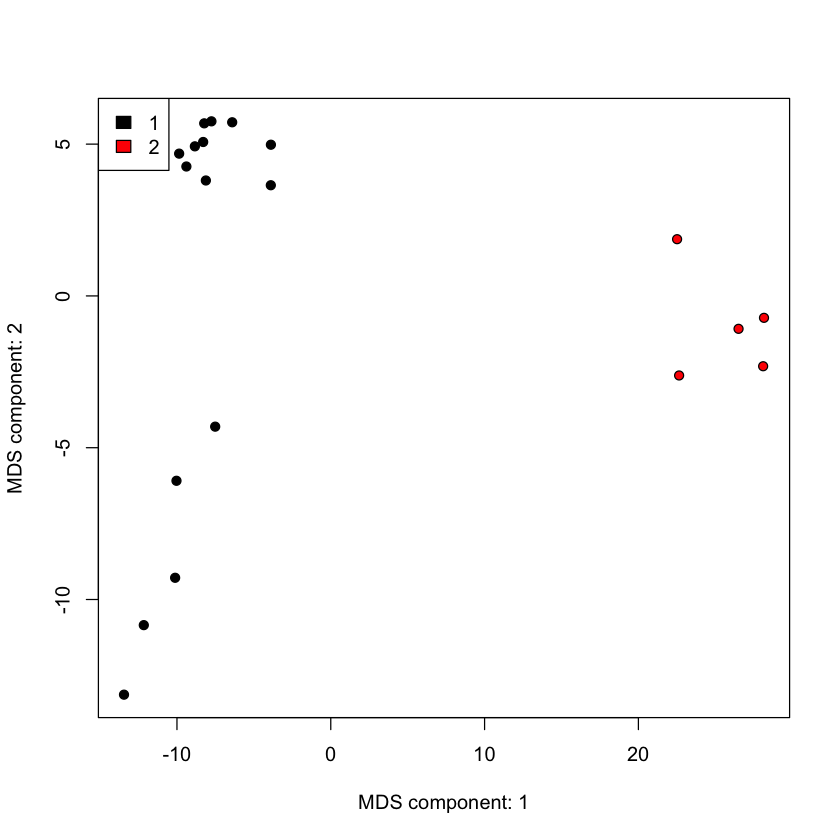

In [10]:
checkMisAnnotation(skin,"GENDER",controlGenes="Y",legendPosition="topleft")

Next, we are intrested in the Subject Phenotype information.
A de-identified, open access version of the sample annotations available in dbGaP.

These are found at the same location: *https://gtexportal.org/home/datasets*


In [21]:
attributes(obj)

$.__classVersion__
            R       Biobase          eSet ExpressionSet 
      "3.6.1"      "2.46.0"       "1.3.0"       "1.0.0" 

$experimentData
Experiment data
  Experimenter name:  
  Laboratory:  
  Contact information:  
  Title:  
  URL:  
  PMIDs:  
  No abstract available.

$assayData
<environment: 0x7ffe642b6580>

$phenoData
An object of class 'AnnotatedDataFrame'
  rowNames: GTEX-1117F-0226-SM-5GZZ7 GTEX-1117F-0426-SM-5EGHI ...
    GTEX-YEC3-1426-101806-SM-5PNXX (17384 total)
  varLabels: SAMPID SMATSSCR ... DTHHRDY (67 total)
  varMetadata: labelDescription

$featureData
An object of class 'AnnotatedDataFrame'
  featureNames: ENSG00000223972.5 ENSG00000227232.5 ...
    ENSG00000210196.2 (55878 total)
  varLabels: ensembl_gene_id hgnc_symbol ... gene_biotype (6 total)
  varMetadata: labelDescription

$annotation
character(0)

$protocolData
An object of class 'AnnotatedDataFrame': none

$class
[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"


ERROR: Error in tissue(obj): could not find function "tissue"


In [15]:
gtex_pheno_url <- 'https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'
gtex_pheno <-'data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'
download.file(gtex_pheno_url, destfile=gtex_pheno)

In [27]:
head(tissue.sets)

[1] "Adipose - Subcutaneous"        "Brain - Frontal Cortex (BA9)" 
[3] "Thyroid"                       "Lung"                         
[5] "Whole Blood"                   "Brain - Cerebellar Hemisphere"

In [30]:
colnames.expression.mat<-colnames(gene_counts.data)

In [32]:
# replace all the dashes with with periods in sample names in the metadata file
meta.data$biospecimen_repository_sample_id<-gsub('-','\\.',meta.data$biospecimen_repository_sample_id)


In [29]:
for (tissue.set in tissue.sets) {
#    print (tissue.set)

    # extract and create an expression matrix from the released dataset
    # skipping the header rows
    # expression.mat<-read.table(gtex_gct, nrow=1,sep='\t',header=T,skip=2)
    # meta.data <- read.csv(dfile, header=FALSE)
    
    # if there is no data, skip and move on
    if (length(table(meta.data$sex_s[meta.data$body_site %in% tissue.set]))==1)
        next

    # if there is no data, skip
    if (sum(meta.data$body_site %in% tissue.set)==0)
        next

    for (col in colnames.expression.mat)
        col.in.tissue<-c(col.in.tissue, 
                         (col %in% meta.data$biospecimen_repository_sample_id) && (meta.data$body_site[which(meta.data$biospecimen_repository_sample_id==col)] %in% tissue.set))
    
#    expression.mat<-read.table(gtex_gct, colClasses = ifelse(col.in.tissue,"numeric","NULL"),sep='\t',header=T,skip=2)

    write.table(expression.mat,paste('data/expression',tissue.set,'.txt',sep=''),sep='\t',quote = F)

#}

[1] "Adipose - Subcutaneous"
[1] "Brain - Frontal Cortex (BA9)"
[1] "Thyroid"
[1] "Lung"
[1] "Whole Blood"
[1] "Brain - Cerebellar Hemisphere"
[1] "Artery - Tibial"
[1] "Cells - EBV-transformed lymphocytes"
[1] "Heart - Left Ventricle"
[1] "Brain - Cortex"
[1] "Muscle - Skeletal"
[1] "Brain - Anterior cingulate cortex (BA24)"
[1] "Brain - Substantia nigra"
[1] "Skin - Sun Exposed (Lower leg)"
[1] "Brain - Hypothalamus"
[1] "Brain - Hippocampus"
[1] "Brain - Caudate (basal ganglia)"
[1] "Brain - Putamen (basal ganglia)"
[1] "Brain - Spinal cord (cervical c-1)"
[1] "Brain - Cerebellum"
[1] "Brain - Nucleus accumbens (basal ganglia)"
[1] "Cells - Leukemia cell line (CML)"
[1] "Brain - Amygdala"
[1] "Nerve - Tibial"
[1] "Vagina"
[1] "Stomach"
[1] "Pancreas"
[1] "Colon - Sigmoid"
[1] "Skin - Not Sun Exposed (Suprapubic)"
[1] "Heart - Atrial Appendage"
[1] "Esophagus - Mucosa"
[1] "Adrenal Gland"
[1] "Breast - Mammary Tissue"
[1] "Liver"
[1] "Esophagus - Muscularis"
[1] "Cells - Cultured fib

In [25]:
for (tissue.set in tissue.sets)
{
    print (tissue.set)
  all.genes<-read.table(gtex_gct,sep='\t',header=T,skip=2,colClasses = c(rep("character", 2), rep("NULL", 11688)))
if (file.size(paste('data/expression',tissue.set,'.txt',sep=''))<=1)

  next

x <- read.delim(paste('data/expression',tissue.set,'.txt',sep=''))

#x<-x[all.genes$Description %in% our.genes,]

#all.genes<-all.genes[all.genes$Description %in% our.genes,2]

x<-x[!duplicated(all.genes[,'Description']),]

all.genes<-all.genes[!duplicated(all.genes[,'Description']),'Description']

rownames(x)<-all.genes

#meta.data<-read.table('/Users/karleg/Dimorph/2017December8GTExRNASeqSRARunTable.txt',sep='\t',header=TRUE)

#meta.data$Sample_Name_s<-gsub('-','\\.',meta.data$Sample_Name_s)

#meta.data<-meta.data[meta.data$Sample_Name_s %in% colnames(x),]

    
pheno<-read.csv(gtex_pheno,sep='\t')

pheno$SUBJID<-gsub('-','\\.',pheno$SUBJID)

sex<-c()  #the value 2 in the phenotypic data is the values that is 1 in design.  This value correslonds to female.

age<-c()

cod<-c()

for (col in colnames(x))
{
  sex<-c(sex,pheno$SEX[which(pheno$SUBJID==paste(unlist(strsplit(col,'\\.'))[c(1,2)],collapse='.'))])

  age<-c(age,pheno$AGE[which(pheno$SUBJID==paste(unlist(strsplit(col,'\\.'))[c(1,2)],collapse='.'))])

  cod<-c(cod,pheno$DTHHRDY[which(pheno$SUBJID==paste(unlist(strsplit(col,'\\.'))[c(1,2)],collapse='.'))])

}

if (length(table(sex))==1)

  next

cod[is.na(cod)]=0
#group <- meta.data$sex_s

y <- DGEList(counts=x,group=factor(sex))

y <- calcNormFactors(y)

groups<-sex

keep.events<-rep(T,nrow(y))

for (group in c(1,2))

  keep.events<-keep.events & (rowSums(cpm(y[,groups %in% group]) > 1) >= 0.25*min(table(groups)))

if (sum(keep.events)==0)

  next

y<-y[keep.events,]  #if only using the logFC to compare with AS then do not screen

design <- model.matrix(~factor(sex))

v <- voom(y, design)

fit <- lmFit(v, design)

fit <- eBayes(fit, robust=TRUE)

res=topTable(fit, coef='factor(sex)2',number=nrow(y))

write.table(res,paste('data/DE_result_',tissue.set,'.txt',sep=''),sep='\t',quote = F)

}
#edgeR

#y <- estimateDisp(y,design)

#fit <- glmFit(y,design)

#lrt <- glmLRT(fit,coef='factor(sex)2')

#hist(lrt$table$PValue)    